<a href="https://colab.research.google.com/github/mukund-23/Pytorch-Tutorial/blob/main/01_Pytorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create data using linear regression

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.002
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [3]:
X.shape, y.shape

(torch.Size([500, 1]), torch.Size([500, 1]))

In [4]:
### Splitting data into train and test set
train_split = int(0.8 * len(X))
#print(train_split)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

400 400 100 100


In [5]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c ='b', label = 'Training data')
    plt.scatter(test_data, test_labels, c='g', label='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', label='Predictions')
    plt.legend()
    plt.show()

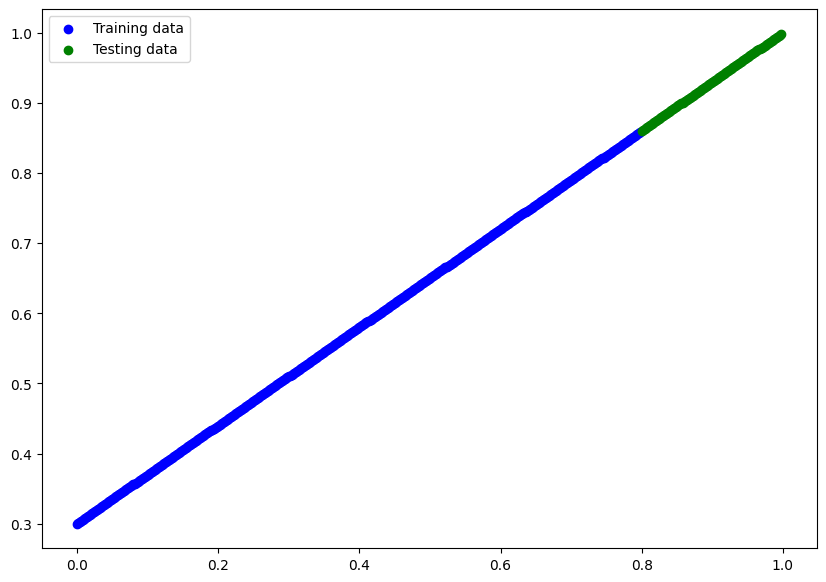

In [6]:
plot_predictions(X_train, y_train, X_test, y_test)

### Building a Pytorch Model

In [7]:
# Create a Linear Regression model Class

class LinearRegression(nn.Module): # <- almost everything in pytorch inherits from NN.module. It is the base class for all neural network modules

  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # <- randn generates a random number from the standard normal distribution
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # <- rand generates a random number from a uniform distribution on [0,1]
    # requires_grad = True -> pytorch tracks the gradient of this specific parameter for use with torch.autograd, and gradient descent

  # forward method to define the computation in the model. Any subclass of nn.Module needs to overwrite the forward() method
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### Pytorch Model Building Essential  
* torch.nn - contains all the building blocks for computational graphs(neural networks)
* torch.nn.parameter - what parameters should the model learn - often a pytorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if we subclass it we should overwrite forward()
* torch.optim - optimizers in pytorch - they will help with gradient descent
* def forward() - All nn.Module subclasses must overwrite this method. It defines what happens in the forward computation

In [8]:
## Checking the content of the pytorch model
# We can do that using  .parameters()

torch.manual_seed(42)

model_0 = LinearRegression()
print(list(model_0.parameters()))
print(model_0.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})


In [9]:
# Make predictions with the model

with torch.inference_mode():
  y_preds = model_0(X_test)

print(len(y_preds))

# we could also replace this (torch.inference_mode()) with y_test = model_0(X_test)
# inference mode turns off gradient tracking, because when we are doing inference we don't need to track the gradient
# It allows faster computation as pytorch has to keep track of lesser numbers

100


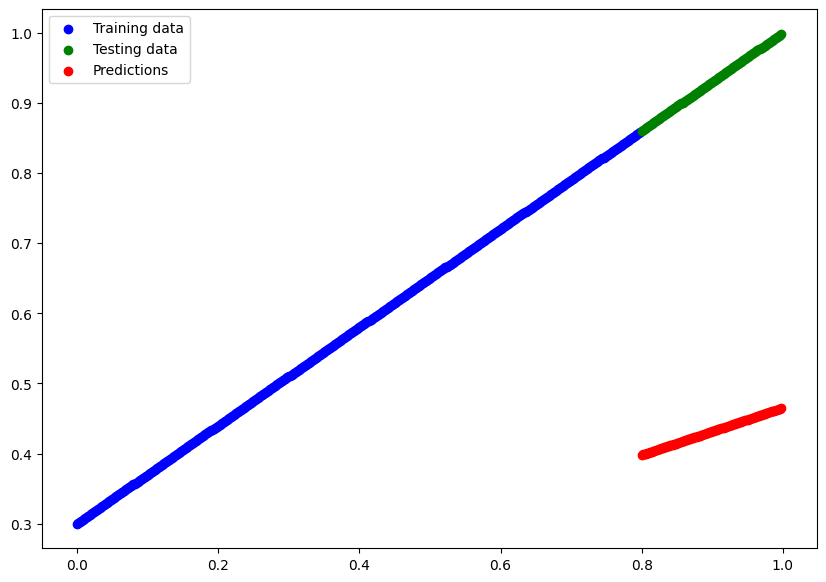

In [10]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

### Training the Model

In [11]:
# Setting up a loss function
loss_fn = nn.L1Loss() # it is the mean absolute error|

# Setting up an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Building a Training Loop in Pytorch

We need
the following things in the training loop
1. Loop through the data  
2. Forward pass - This involves data moving through our model's forward pass - also called forward propagation  
3. Calculate the loss - compare forward pass predictions to ground truth labels
4. Optimize zero grad  
5. Loss Backward - move backwards through the network to calculate the gradients of each parameters of the model w.r.t the loss  
6. Optimizer Step - Use the optimizer to adjust the model parameters to improve the loss  

In [12]:
torch.manual_seed(42) # for reproducibility of training results
# 1 loop through the data
epochs = 100
epoch_count = []
loss_values = []
test_loss_values = []
for epoch in range(epochs):
  #  set the model to train mode - train mode in pytorch sets all parameters that require gradients to require gradients
  model_0.train()

  # 1. forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad() # by default how the optimizer changes will accumulate over multiple iterations of the loop.
                        # we have to zero them in step 3 for the next iteration of the loop
  # 4. loss backward
  loss.backward()  # Perform backpropagation on the loss function (compute the gradient of every parameter with requires_grad = True)

  # 5. optimizer step (perform gradient descent)
  optimizer.step() # It updates the model's parameters with respect to the gradients calculated by loss.backward()

  # Testing
  model_0.eval() # Turns of different settings ithe model that are not eeded for evaluation/testing (dropout/batch norm layers)

  with torch.inference_mode(): # Turns off gradient tracking & a couple of more thigs not needed for testing
    test_pred = model_0(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch%10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test loss: {test_loss} ")
    # Print out the model state_dict
    print(model_0.state_dict())



Epoch: 0 | Train Loss: 0.31615114212036133 | Test loss: 0.484218955039978 
OrderedDict({'weights': tensor([0.3407]), 'bias': tensor([0.1388])})
Epoch: 10 | Train Loss: 0.20023101568222046 | Test loss: 0.34834885597229004 
OrderedDict({'weights': tensor([0.3806]), 'bias': tensor([0.2388])})
Epoch: 20 | Train Loss: 0.08987633883953094 | Test loss: 0.21738135814666748 
OrderedDict({'weights': tensor([0.4203]), 'bias': tensor([0.3341])})
Epoch: 30 | Train Loss: 0.05263463407754898 | Test loss: 0.14330445230007172 
OrderedDict({'weights': tensor([0.4536]), 'bias': tensor([0.3782])})
Epoch: 40 | Train Loss: 0.044976845383644104 | Test loss: 0.11211289465427399 
OrderedDict({'weights': tensor([0.4773]), 'bias': tensor([0.3881])})
Epoch: 50 | Train Loss: 0.04120706021785736 | Test loss: 0.09747876226902008 
OrderedDict({'weights': tensor([0.4963]), 'bias': tensor([0.3857])})
Epoch: 60 | Train Loss: 0.037771862000226974 | Test loss: 0.08799232542514801 
OrderedDict({'weights': tensor([0.5137]),

In [13]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

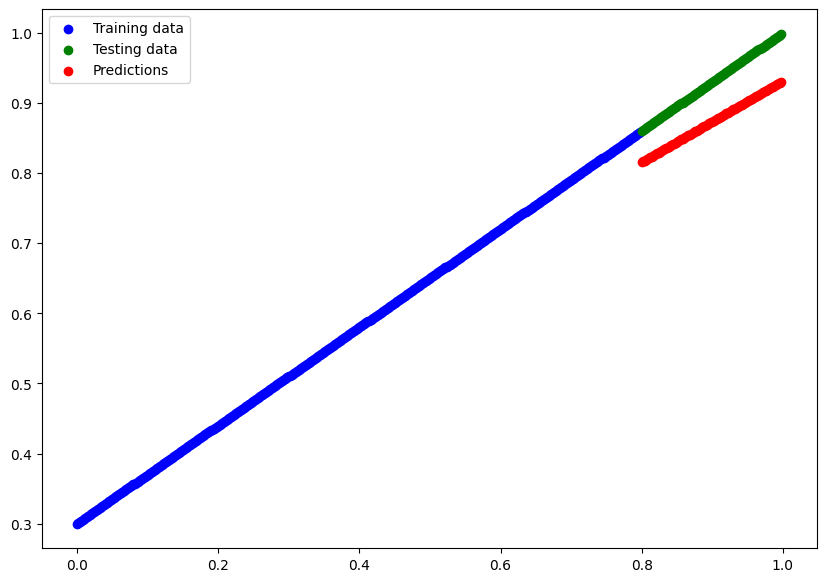

In [14]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds_new)

/tmp/ipython-input-1853771415.py:1: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train Loss') # for plotting we need to convert tensor to numpy


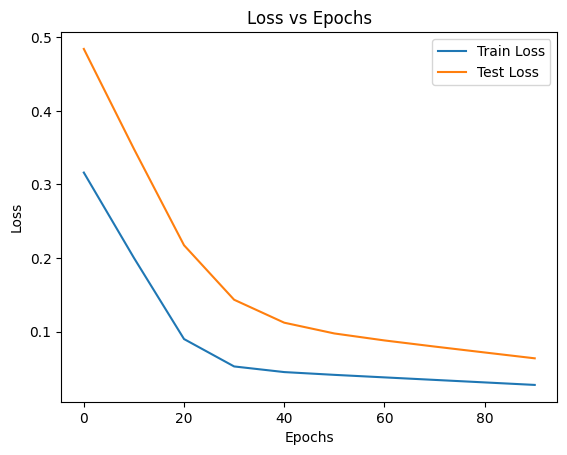

In [15]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train Loss') # for plotting we need to convert tensor to numpy
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Saving a Model
There are 3 main methods for saving and loading a model
1. `torch.save()` - allows to save a Pytorch object in Python's pickle format
2. `torch.load()` - allows to laod a saved Pytorch object
3. `torch.nn.Module.load_state_dict()` - this allows to save a model's saved state dictionary
State Dict - It is a python dictionary object that maps each layer to its parameter tensor. Only the layers with learnable parameters and registered buffers have entries in the model's state_dict  
Model optimizer also has a state dict

In [16]:
## Saving the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
# Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # Pytroch objects have the extension pth for pytorch
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_0.pth')

In [17]:
# Saving the model state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [18]:
# Loading a PyTorch Model
# Since we saved our model's `state_dict()` rather than the enire model, we'll crate a new instace of our model class and load the saved state_dict() into that

loaded_model_0 = LinearRegression()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [19]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5801])), ('bias', tensor([0.3513]))])